

# Portfolio Management-Eigen Portfolio

In this case study we use dimensionality reduction techniques for portfolio management and allocation.


## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)
    * [4.3.Data Transformation](#3.2)  
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train Test Split](#4.1)
    * [5.2. Model Evaluation- Applying Principle Component Analysis](#4.2)
        * [5.2.1. Explained Variance using PCA](#4.2.1)
        * [5.2.2. Looking at Portfolio weights](#4.2.2)
        * [5.2.3. Finding the Best Eigen Portfolio](#4.2.3)
        * [5.2.4. Backtesting Eigenportfolio](#4.2.4)

<a id='0'></a>
# 1. Problem Definition

Our goal in this case study is to maximize risk-adjusted returns using dimensionality
reduction-based algorithm on a dataset of stocks to allocate capital into different asset
classes.

The dataset used for this case study is ETFs and sotcks from Chile's roboadvisors from year 2010 onwards till 2022. The dataset can be downloaded from
yahoo finance.

https://www.soyfocus.com/


<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

#Import Model Packages 
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import inv, eig, svd

from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA
import yfinance as yf


<a id='1.2'></a>
## 2.2. Loading the Data

help(yf.Ticker)

In [45]:

stocks_names = ["ITOT","IVV","QQQ","VTI","CXSE","IJR","0LMR.L",
                "VPL","VWO","SUSA","CEMB","HYEM","MGV","USHY"]

In [46]:
yf.Ticker("USHY").info["shortName"]

'iShares Broad USD High Yield Co'

In [47]:
dataset = pd.DataFrame()

In [48]:
stocks = []
for s in stocks_names:
    value = yf.Ticker(s).history(period = "10y").Close
    dat = pd.DataFrame({"{}".format(s): value})
    dataset = pd.concat([dataset,dat],axis = 1)

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [49]:
# shape
dataset.shape

(2519, 14)

In [50]:
# peek at data
set_option('display.width', 100)
dataset.head(5)

,ITOT,IVV,QQQ,VTI,CXSE,IJR,0LMR.L,VPL,VWO,SUSA,CEMB,HYEM,MGV,USHY
Date,,,,,,,,,,,,,,
2012-12-10,26.787,118.608,59.237,60.885,24.014,33.223,NaN,39.921,32.849,25.677,35.782,14.664,33.176,NaN
2012-12-11,26.960,119.295,60.011,61.268,24.049,33.514,NaN,40.074,33.016,25.824,35.636,14.785,33.394,NaN
2012-12-12,26.948,119.461,59.883,61.293,24.036,33.345,NaN,40.257,33.145,25.793,35.656,14.736,33.495,NaN
2012-12-13,26.832,118.715,59.410,60.944,23.784,33.171,NaN,40.104,32.986,25.677,35.649,14.752,33.285,NaN
2012-12-14,26.671,118.301,58.846,60.686,23.987,33.106,NaN,40.181,33.153,25.608,35.835,14.752,33.230,NaN


In [51]:
# types
set_option('display.max_rows', 500)
dataset.dtypes

ITOT      float64
IVV       float64
QQQ       float64
VTI       float64
CXSE      float64
IJR       float64
0LMR.L    float64
VPL       float64
VWO       float64
SUSA      float64
CEMB      float64
HYEM      float64
MGV       float64
USHY      float64
dtype: object

In [52]:
# describe data
set_option('precision', 3)
dataset.describe()

,ITOT,IVV,QQQ,VTI,CXSE,IJR,0LMR.L,VPL,VWO,SUSA,CEMB,HYEM,MGV,USHY
count,2519.000,2519.000,2519.000,2519.000,2441.000,2519.000,1.00,2519.000,2519.000,2519.000,2518.000,2519.000,2519.000,1283.000
mean,57.901,255.414,174.312,130.610,34.960,68.482,56.95,57.920,36.956,54.693,40.842,17.497,65.567,36.271
std,21.295,94.870,94.239,47.882,13.002,21.341,NaN,10.585,6.321,21.098,4.916,2.212,19.756,2.110
min,26.533,117.291,58.341,60.371,17.781,33.106,56.95,39.921,23.812,25.502,31.992,13.777,32.911,27.538
25%,40.848,179.955,99.833,92.418,23.832,50.316,56.95,48.462,32.429,37.996,36.209,15.393,49.272,34.463
50%,54.147,237.648,149.396,121.725,33.090,65.382,56.95,57.755,35.786,50.176,40.540,17.571,64.209,37.136
75%,70.355,312.732,237.907,158.409,41.118,79.852,56.95,64.332,40.398,66.398,44.653,19.028,75.260,37.908
max,106.431,474.319,401.487,240.230,79.277,118.389,56.95,82.723,53.773,105.568,50.104,21.911,107.723,39.919


<a id='2.2'></a>
## 3.2. Data Visualization

Taking a look at the correlation. More detailed look at the data will be performed after implementing the Dimensionality Reduction Models.

<AxesSubplot:title={'center':'Correlation Matrix'}>

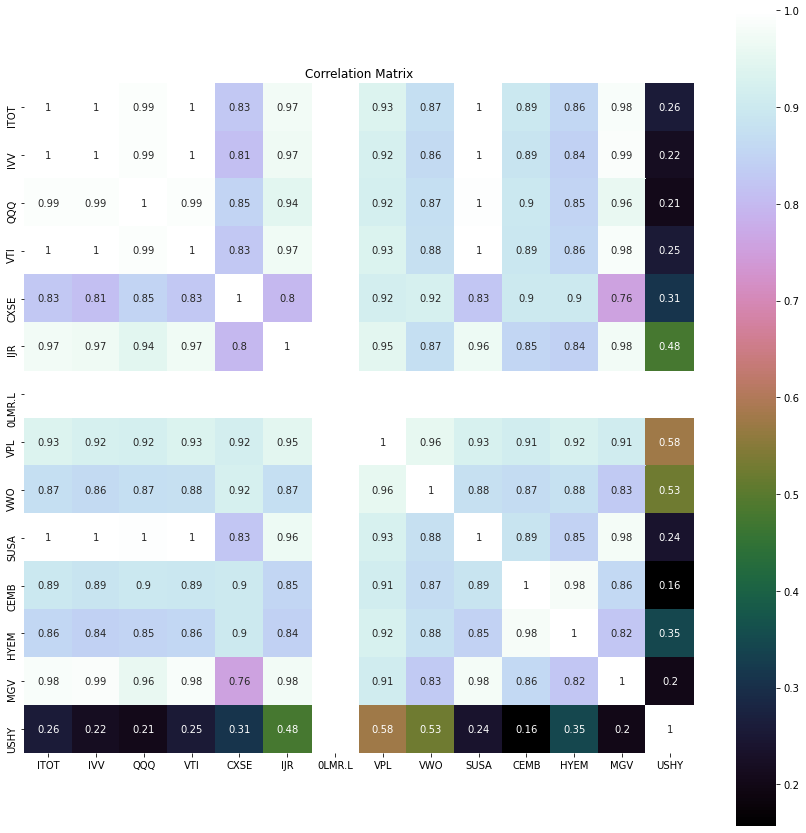

In [53]:
# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

As it can be seen by the chart above, there is a significant positive correlation between
the stocks. 

<a id='3'></a>
## 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning
Let us check for the NAs in the rows, either drop them or fill them with the mean of the column

In [54]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = True


Getting rid of the columns with more than 30% missing values. 

In [55]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(2519, 12)

Given that there are null values drop the rown contianing the null values.

In [56]:
# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')

# Drop the rows containing NA
dataset= dataset.dropna(axis=0)
# Fill na with 0
#dataset.fillna('0')

dataset.head(2)

,ITOT,IVV,QQQ,VTI,CXSE,IJR,VPL,VWO,SUSA,CEMB,HYEM,MGV
Date,,,,,,,,,,,,
2012-12-10,26.787,118.608,59.237,60.885,24.014,33.223,39.921,32.849,25.677,35.782,14.664,33.176
2012-12-11,26.960,119.295,60.011,61.268,24.049,33.514,40.074,33.016,25.824,35.636,14.785,33.394


Computing Daily Return

In [57]:
# Daily Log Returns (%)
# datareturns = np.log(data / data.shift(1)) 

# Daily Linear Returns (%)
datareturns = dataset.pct_change(1)

#Remove Outliers beyong 3 standard deviation
datareturns= datareturns[datareturns.apply(lambda x :(x-x.mean()).abs()<(3*x.std()) ).all(1)]

<a id='3.2'></a>
## 4.2. Data Transformation

All the variables should be on the same scale before applying PCA, otherwise a feature with large values will dominate the result. Below we use StandardScaler in sklearn to standardize the dataset’s features onto unit scale (mean = 0 and variance = 1).

Standardization is a useful technique to transform attributes to a standard Normal distribution with a mean of
0 and a standard deviation of 1.

In [58]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(datareturns)
rescaledDataset = pd.DataFrame(scaler.fit_transform(datareturns),columns = datareturns.columns, index = datareturns.index)
# summarize transformed data
datareturns.dropna(how='any', inplace=True)
rescaledDataset.dropna(how='any', inplace=True)
rescaledDataset.head(2)

,ITOT,IVV,QQQ,VTI,CXSE,IJR,VPL,VWO,SUSA,CEMB,HYEM,MGV
Date,,,,,,,,,,,,
2012-12-11,0.679,0.608,1.121,0.656,0.074,0.745,0.400,0.450,0.588,-1.070,2.074,0.755
2012-12-12,-0.143,0.077,-0.287,-0.040,-0.066,-0.522,0.489,0.338,-0.226,0.104,-0.919,0.300


<AxesSubplot:xlabel='Date'>

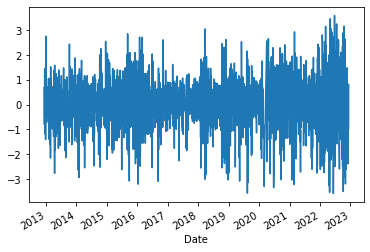

In [59]:
# Visualizing Log Returns for the DJIA 
#plt.figure(figsize=(16, 5))
#plt.title("AAPL Return")
#plt.ylabel("Return")
rescaledDataset.ITOT.plot()
#plt.grid(True);
#plt.legend()
#plt.show()

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split

The portfolio is divided into train and test split to perform the analysis regarding the best porfolio and backtesting shown later. 

In [60]:
# Dividing the dataset into training and testing sets
percentage = int(len(rescaledDataset) * 0.7)
X_train = rescaledDataset[:percentage]
X_test = rescaledDataset[percentage:]

X_train_raw = datareturns[:percentage]
X_test_raw = datareturns[percentage:]


stock_tickers = rescaledDataset.columns.values
n_tickers = len(stock_tickers)

<a id='4.2'></a>
## 5.2. Model Evaluation- Applying Principle Component Analysis

As this step, we create a function to compute principle component analysis from sklearn. This function computes an inversed elbow chart that shows the amount of principle components and how many of them explain the variance treshold.

In [61]:
pca = PCA()
PrincipalComponent=pca.fit(X_train)

### First Principal Component /Eigenvector

In [62]:
pca.components_[0]

array([-0.33597371, -0.3389856 , -0.30516189, -0.33705698, -0.19941087,
       -0.29073756, -0.3149807 , -0.31964233, -0.32631248, -0.05675544,
       -0.12538813, -0.33819958])

<a id='4.2.1'></a>
## 5.2.1.Explained Variance using PCA

,Explained Variance
0,65.05%
1,76.99%
2,84.37%
3,90.69%
4,94.14%
5,96.10%
6,97.96%
7,99.36%
8,99.82%
9,99.95%


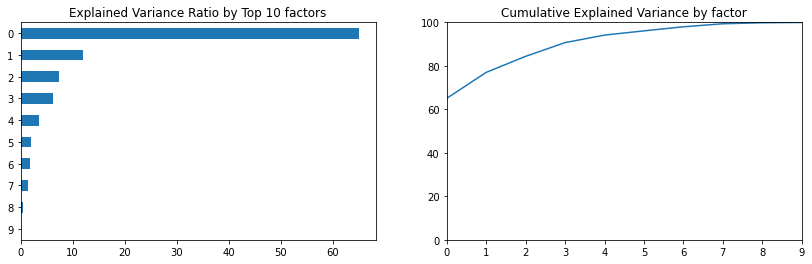

In [63]:
NumEigenvalues=10
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
Series1 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).sort_values()*100
Series2 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).cumsum()*100
Series1.plot.barh(ylim=(0,9), label="woohoo",title='Explained Variance Ratio by Top 10 factors',ax=axes[0]);
Series2.plot(ylim=(0,100),xlim=(0,9),ax=axes[1], title='Cumulative Explained Variance by factor');
# explained_variance
pd.Series(np.cumsum(pca.explained_variance_ratio_)).to_frame('Explained Variance').head(NumEigenvalues).style.format('{:,.2%}'.format)

We find that the most important factor explains around 40% of the daily return variation. The dominant factor is usually interpreted as ‘the market’, depending on the results of closer inspection.

The plot on the right shows the cumulative explained variance and indicates that around 10 factors explain 71% of the returns of this large cross-section of stocks.  

<a id='4.2.2'></a>
## 5.2.2.Looking at Portfolio weights

We compute several functions to determine the weights of each principle component. We then visualize a scatterplot that visualizes an organized descending plot with the respective weight of every company at the current chosen principle component.

In [64]:
def PCWeights():
    '''
    Principal Components (PC) weights for each 52 PCs
    '''
    weights = pd.DataFrame()

    for i in range(len(pca.components_)):
        weights["weights_{}".format(i)] = pca.components_[i] / sum(pca.components_[i])

    weights = weights.values.T
    return weights

weights=PCWeights()

In [65]:
weights[0]

array([0.10216298, 0.10307884, 0.09279371, 0.10249238, 0.06063691,
       0.08840756, 0.09577942, 0.09719693, 0.09922519, 0.01725821,
       0.03812806, 0.10283982])

array([[<AxesSubplot:title={'center':'Portfolio 0'}>],
       [<AxesSubplot:title={'center':'Portfolio 1'}>]], dtype=object)

<Figure size 1152x648 with 0 Axes>

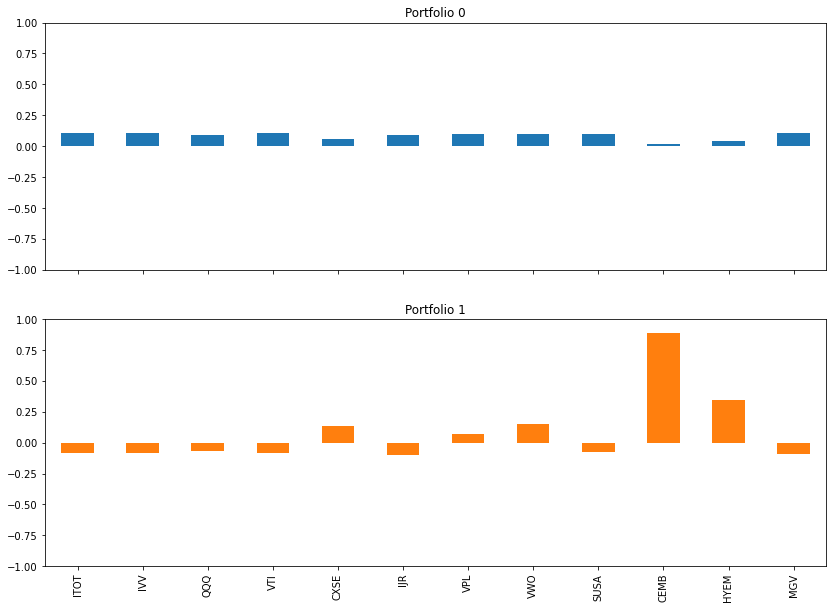

In [66]:
NumComponents=2
fig = plt.figure(figsize=(16,9))
topPortfolios = pd.DataFrame(pca.components_[:NumComponents], columns=dataset.columns)
eigen_portfolios = topPortfolios.div(topPortfolios.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range( NumComponents)]
np.sqrt(pca.explained_variance_)
eigen_portfolios.T.plot.bar(subplots=True, layout=(int(NumComponents),1), figsize=(14,10), legend=False, sharey=True, ylim= (-1,1))

<AxesSubplot:>

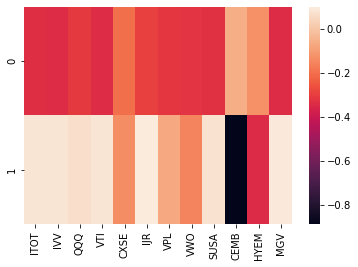

In [67]:
# plotting heatmap 
sns.heatmap(topPortfolios) 

The heatmap and the plot above shown the contribution of different stocks in each
eigenvector.

<a id='4.2.3'></a>
## 5.2.3. Finding the Best Eigen Portfolio

In order to find the best eigen portfolios and perform backtesting in the next step, we use the sharpe ratio, which is a performance
metric that explains the annualized returns against the annualized volatility of each company in a portfolio. A high sharpe ratio explains higher returns and/or lower volatility for the specified portfolio. The annualized sharpe ratio is computed by dividing
the annualized returns against the annualized volatility. For annualized return we
apply the geometric average of all the returns in respect to the periods per year (days
of operations in the exchange in a year). Annualized volatility is computed by taking the standard deviation of the returns and multiplying it by the square root of the peri‐
ods per year.

In [68]:
# Sharpe Ratio
def sharpe_ratio(ts_returns, periods_per_year=252):
    '''
    Sharpe ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk.
    It calculares the annualized return, annualized volatility, and annualized sharpe ratio.
    
    ts_returns are  returns of a signle eigen portfolio.
    '''
    n_years = ts_returns.shape[0]/periods_per_year
    annualized_return = np.power(np.prod(1+ts_returns),(1/n_years))-1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe

We construct a loop to compute the principle component’s weights for each eigen
portfolio, which then uses the sharpe ratio function to look for the portfolio with the
highest sharpe ratio. Once we know which portfolio has the highest sharpe ratio, we
can visualize its performance against the DJIA Index for comparison.

[0.10216298 0.10307884 0.09279371 0.10249238 0.06063691 0.08840756
 0.09577942 0.09719693 0.09922519 0.01725821 0.03812806 0.10283982]
      weights
IVV    10.308
MGV    10.284
VTI    10.249
ITOT   10.216
SUSA    9.923
VWO     9.720
VPL     9.578
QQQ     9.279
IJR     8.841
CXSE    6.064
HYEM    3.813
CEMB    1.726
[-0.0832556  -0.08135913 -0.06778306 -0.08302886  0.13222505 -0.10061495
  0.0667225   0.15403787 -0.07696785  0.89101473  0.34215997 -0.09315068]
      weights
CEMB   89.101
HYEM   34.216
VWO    15.404
CXSE   13.223
VPL     6.672
QQQ    -6.778
SUSA   -7.697
IVV    -8.136
VTI    -8.303
ITOT   -8.326
MGV    -9.315
IJR   -10.061
[-1.54340035 -1.51647072 -1.01222857 -1.55122197  6.61533898 -1.63261734
  2.04319125  4.20378113 -1.41278848 -3.68439509  2.17706413 -1.68625298]
      weights
CXSE  661.534
VWO   420.378
HYEM  217.706
VPL   204.319
QQQ  -101.223
SUSA -141.279
IVV  -151.647
ITOT -154.340
VTI  -155.122
IJR  -163.262
MGV  -168.625
CEMB -368.440
[ 0.08186627  0.09587964 

/home/martin/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2566: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


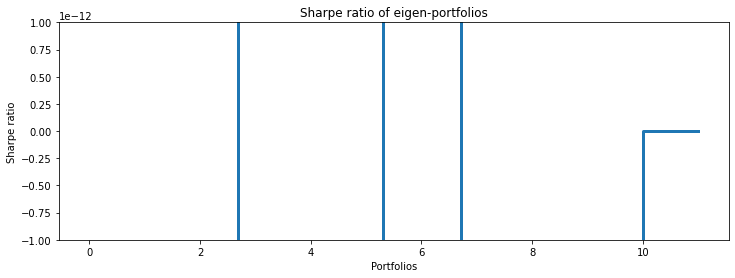

In [72]:
def optimizedPortfolio():
    n_portfolios = len(pca.components_)
    annualized_ret = np.array([0.] * n_portfolios)
    sharpe_metric = np.array([0.] * n_portfolios)
    annualized_vol = np.array([0.] * n_portfolios)
    highest_sharpe = 0 
    stock_tickers = rescaledDataset.columns.values
    n_tickers = len(stock_tickers)
    pcs = pca.components_
    
    for i in range(10):
        
        pc_w = pcs[i] / sum(pcs[i])
        print(pc_w)
        eigen_prtfi = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
        eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)
        print(eigen_prtfi)
        eigen_prti_returns = np.dot(X_train_raw.loc[:, eigen_prtfi.index], pc_w)

        eigen_prti_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_train_raw.index)
        er, vol, sharpe = sharpe_ratio(eigen_prti_returns)
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe
        
        sharpe_metric= np.nan_to_num(sharpe_metric)
        
    # find portfolio with the highest Sharpe ratio
    highest_sharpe = np.argmax(sharpe_metric)

    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (highest_sharpe,
           annualized_ret[highest_sharpe]*100, 
           annualized_vol[highest_sharpe]*100, 
           sharpe_metric[highest_sharpe]))


    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

    results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
    results.dropna(inplace=True)
    results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
    print(results.head(20))

    plt.show()

optimizedPortfolio()

As shown from the results above, the portfolio 12 is the best portfolio and has the maximum sharp ratio out of all the porfolio. Let us look at the composition of this portfolio. 

In [74]:
weights = PCWeights()
portfolio = portfolio = pd.DataFrame()

def plotEigen(weights, plot=False, portfolio=portfolio):
    portfolio = pd.DataFrame(data ={'weights': weights.squeeze()*100}, index = stock_tickers) 
    portfolio.sort_values(by=['weights'], ascending=False, inplace=True)
    if plot:
        print('Sum of weights of current eigen-portfolio: %.2f' % np.sum(portfolio))
        portfolio.plot(title='Current Eigen-Portfolio Weights', 
            figsize=(12,6), 
            xticks=range(0, len(stock_tickers),1), 
            rot=45, 
            linewidth=3
            )
        plt.show()


    return portfolio

Sum of weights of current eigen-portfolio: 100.00


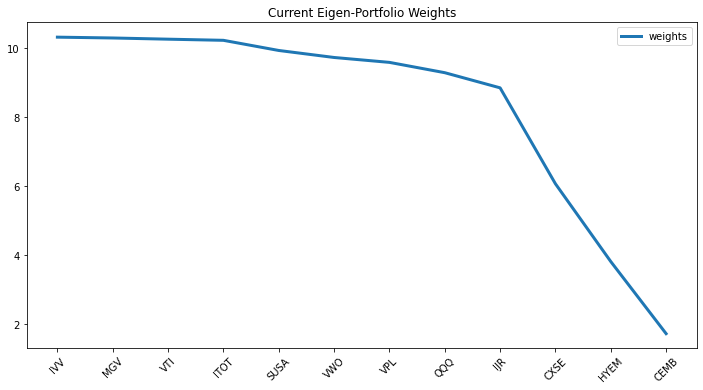

,weights
IVV,10.308
MGV,10.284
VTI,10.249
ITOT,10.216
SUSA,9.923
VWO,9.720
VPL,9.578
QQQ,9.279
IJR,8.841
CXSE,6.064


In [75]:
# Weights are stored in arrays, where 0 is the first PC's weights.
plotEigen(weights=weights[0], plot=True)

The chart shows the allocation of the best portfolio. The weights in the chart are in
percentages. 

<a id='4.2.4'></a>
## 5.2.4. Backtesting Eigenportfolio

We will now try to backtest this algorithm on the test set, by looking at few top and bottom portfolios.

ITOT   -0.004
IVV    -0.004
QQQ    -0.010
VTI    -0.004
CXSE   -0.015
IJR    -0.006
VPL    -0.004
VWO    -0.003
SUSA   -0.002
CEMB    0.004
HYEM    0.001
MGV    -0.002
Name: 2019-10-18 00:00:00, dtype: float64 ITOT   -0.007
IVV    -0.007
QQQ    -0.006
VTI    -0.008
CXSE   -0.009
IJR    -0.011
VPL     0.004
VWO    -0.008
SUSA   -0.009
CEMB   -0.004
HYEM    0.002
MGV    -0.009
Name: 2022-12-09 00:00:00, dtype: float64
Current Eigen-Portfolio:
Return = 17.65%
Volatility = 13.62%
Sharpe = 1.30


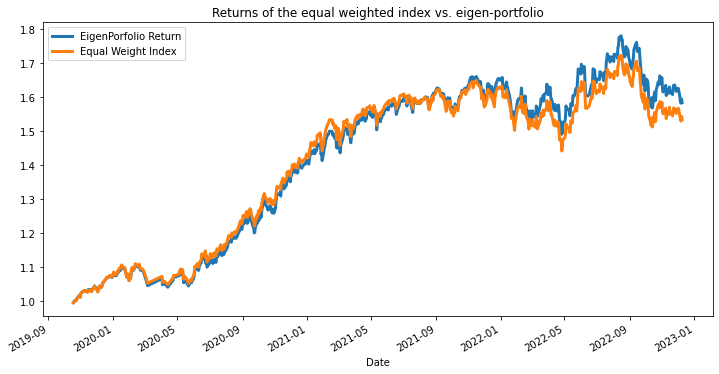

In [80]:
def Backtest(eigen):

    '''

    Plots Principle components returns against real returns.
    
    '''
   
    eigen_prtfi = pd.DataFrame(data ={'weights': eigen.squeeze()}, index = stock_tickers)
    eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)    

    eigen_prti_returns = np.dot(X_test_raw.loc[:, eigen_prtfi.index], eigen)
    eigen_portfolio_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_test_raw.index)
    returns, vol, sharpe = sharpe_ratio(eigen_portfolio_returns)  
    print('Current Eigen-Portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (returns*100, vol*100, sharpe))
    equal_weight_return=(X_test_raw * (1/len(pca.components_))).sum(axis=1)    
    df_plot = pd.DataFrame({'EigenPorfolio Return': eigen_portfolio_returns, 'Equal Weight Index': equal_weight_return}, index=X_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the equal weighted index vs. eigen-portfolio' , 
                          figsize=(12,6), linewidth=3)
    
    
    #print(DJ)
    #plt.plot(DJ[int(len(DJ)*0.8):]/DJ[int(len(DJ)*0.8)])
    plt.show()
print(X_test_raw.iloc[0],X_test_raw.iloc[-1]) 
Backtest(eigen=weights[0])
#Backtest(eigen=weights[1])


In [77]:
X_test.index[0]

Timestamp('2019-10-18 00:00:00')

As shown in charts above the eigen portfolio return of the top portfolios outperform
the equally weighted portfolio and the eigen portfolio ranked 19 underperformed the
market significantly in the test set. 

__Conclusion__

In terms of the intuition behind the eigen portfolios, we demonstrated that the first
eigen portfolio represents a systematic risk factor and other eigen portfolio may represent sector or industry factor. We discuss diversification benefits offered by the eigen
portfolios as they are derived using PCA and are independent.


Looking at the backtesting result, the portfolio with the best result in the training set
leads to the best result in the test set. By using PCA, we get independent eigen portfo‐
lios with higher return and sharp ratio as compared to market.


In [35]:
import cvxopt as opt
from cvxopt import blas, solvers

In [36]:
def get_asset_allocation(riskTolerance,stock_ticker):
    #ipdb.set_trace()
    assets_selected = assets.loc[:,stock_ticker]
    return_vec = np.array(assets_selected.pct_change().dropna(axis=0)).T
    n = len(return_vec)
    returns = np.asmatrix(return_vec)
    mus = 1-riskTolerance
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(return_vec))
    pbar = opt.matrix(np.mean(return_vec, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = solvers.qp(mus*S, -pbar, G, h, A, b)
    w=portfolios['x'].T
    print (w)
    Alloc =  pd.DataFrame(data = np.array(portfolios['x']),index = assets_selected.columns)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = solvers.qp(mus*S, -pbar, G, h, A, b)
    returns_final=(np.array(assets_selected) * np.array(w))
    returns_sum = np.sum(returns_final,axis =1)
    returns_sum_pd = pd.DataFrame(returns_sum, index = assets.index )
    returns_sum_pd = returns_sum_pd - returns_sum_pd.iloc[0,:] + 100   
    return Alloc,returns_sum_pd

$$
\mathcal{L} = \bar{x}^T \mu \mathbf{S} \bar{x}  - \mathbf{R}  x\\
\sum x = 1 \\
 x_{i} > 0 
$$

In [41]:
riskTolerance = 1

mus = 1-riskTolerance
n = len(datareturns.T)
print(n)
# Convert to cvxopt matrices
S = opt.matrix(np.cov(datareturns.T))
pbar = opt.matrix(np.mean(datareturns.T, axis=1))

# Create constraint matrices
G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
h = opt.matrix(0.0, (n ,1))
A = opt.matrix(1.0, (1, n))
b = opt.matrix(1.0)

# Calculate efficient frontier weights using quadratic programming
portfolios = solvers.qp(mus*S, -pbar, G, h, A, b)
w=portfolios['x'].T
print (w)

13
     pcost       dcost       gap    pres   dres
 0: -5.5290e-04 -1.0010e+00  1e+00  2e-16  4e+00
 1: -5.5305e-04 -1.0990e-02  1e-02  2e-16  4e-02
 2: -5.6625e-04 -1.0899e-03  5e-04  7e-17  2e-03
 3: -9.3428e-04 -1.1608e-03  2e-04  2e-16  2e-04
 4: -9.7687e-04 -9.9163e-04  1e-05  1e-16  1e-05
 5: -9.8979e-04 -9.8994e-04  2e-07  1e-16  1e-07
 6: -9.8992e-04 -9.8992e-04  2e-09  1e-16  1e-09
Optimal solution found.
[ 1.12e-08  1.11e-06  1.23e-06  1.00e+00  1.10e-06  3.97e-08  3.39e-07 ... ]



In [42]:
for i,ww in enumerate(w):
    print(i,ww)

0 1.1212098768800132e-08
1 1.1088526619306669e-06
2 1.2331830538819965e-06
3 0.999994552389267
4 1.1022399864872561e-06
5 3.9650007184845955e-08
6 3.3882384014414216e-07
7 4.863848364638396e-08
8 2.514762299311416e-08
9 9.706211546391759e-07
10 1.1900027246135151e-08
11 1.351147661021412e-08
12 5.438303194096265e-07


In [43]:
datareturns.T.iloc[3]

Date
2012-12-04   -6.088e-04
2012-12-05   -1.112e-02
2012-12-06    6.472e-03
2012-12-07   -5.971e-03
2012-12-10    2.926e-03
                ...    
2022-11-25   -6.578e-03
2022-11-28   -1.467e-02
2022-11-29   -7.570e-03
2022-12-01    1.227e-03
2022-12-02   -3.983e-03
Name: QQQ, Length: 2374, dtype: float64

In [140]:
x = np.linspace(0,1)

In [148]:
x3 = np.tile(x,(len(x),len(x),1))
y3 = np.zeros_like(x3)
z3 = np.zeros_like(x3)
for i in range(len(x)):
    y3[:,i,:] = x3[:,:,i]
for i in range(len(x)):
    z3[i,:,:] = x3[:,:,i]


In [144]:
yy3 = np.tile(x,(len(x),len(x),1))


(50, 50, 50)

In [159]:
z3[0,:,:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])